# XM100

In [19]:
from datasets import Image, load_dataset
import datasets

/home/olivernan_cohere_com/miniconda3/envs/instructmultilingual/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
aya23_nllbcode2lang ={
    "arb_Arab": "Modern Standard Arabic",
    "zho_Hans": "Chinese (Simplified)",
    "zho_Hant": "Chinese (Traditional)",
    "ces_Latn": "Czech",
    "nld_Latn": "Dutch",
    "eng_Latn": "English",
    "fra_Latn": "French",
    "deu_Latn": "German",
    "ell_Grek": "Greek",
    "heb_Hebr": "Hebrew",
    "hin_Deva": "Hindi",
    "ind_Latn": "Indonesian",
    "ita_Latn": "Italian",
    "jpn_Jpan": "Japanese",
    "kor_Hang": "Korean",
    "pes_Arab": "Western Persian",
    "pol_Latn": "Polish",
    "por_Latn": "Portuguese",
    "ron_Latn": "Romanian",
    "rus_Cyrl": "Russian",
    "spa_Latn": "Spanish",
    "tur_Latn": "Turkish",
    "ukr_Cyrl": "Ukrainian",
    "vie_Latn": "Vietnamese",
}

aya23_nllbcode2cloudcode ={
    "arb_Arab": "ar",
    "zho_Hans": "zh-CN",
    "zho_Hant": "zh-TW",
    "ces_Latn": "cs",
    "nld_Latn": "nl",
    "eng_Latn": "en",
    "fra_Latn": "fr",
    "deu_Latn": "de",
    "ell_Grek": "el",
    "heb_Hebr": "he",
    "hin_Deva": "hi",
    "ind_Latn": "id",
    "ita_Latn": "it",
    "jpn_Jpan": "ja",
    "kor_Hang": "ko",
    "pes_Arab": "fa",
    "pol_Latn": "pl",
    "por_Latn": "pt",
    "ron_Latn": "ro",
    "rus_Cyrl": "ru",
    "spa_Latn": "es",
    "tur_Latn": "tr",
    "ukr_Cyrl": "uk",
    "vie_Latn": "vi",
}

aya23_cloudcode2nllbcode = {v: k for k, v in aya23_nllbcode2cloudcode.items()}

In [202]:
aya23_nllbcode2cloudcode.keys()

dict_keys(['arb_Arab', 'zho_Hans', 'zho_Hant', 'ces_Latn', 'nld_Latn', 'eng_Latn', 'fra_Latn', 'deu_Latn', 'ell_Grek', 'heb_Hebr', 'hin_Deva', 'ind_Latn', 'ita_Latn', 'jpn_Jpan', 'kor_Hang', 'pes_Arab', 'pol_Latn', 'por_Latn', 'ron_Latn', 'rus_Cyrl', 'spa_Latn', 'tur_Latn', 'ukr_Cyrl', 'vie_Latn'])

In [31]:
xm100 = datasets.load_dataset('neulab/PangeaBench-xm100')
xm100.keys()

dict_keys(['ar', 'bn', 'cs', 'da', 'de', 'el', 'en', 'es', 'fa', 'fi', 'fil', 'fr', 'hi', 'hr', 'hu', 'id', 'it', 'he', 'ja', 'ko', 'mi', 'nl', 'no', 'pl', 'pt', 'quz', 'ro', 'ru', 'sv', 'sw', 'te', 'th', 'tr', 'uk', 'vi', 'zh'])

In [30]:
from PIL import Image
from io import BytesIO
import base64
import io 
import math

def to_bytes(image):
    img_byte_arr = io.BytesIO()
    image.convert("RGB").save(img_byte_arr, format="jpeg")
    return img_byte_arr.getvalue()

def resize_and_pad_image(image, target_resolution):
    """
    Resize and pad an image to a target resolution while maintaining aspect ratio.

    Args:
        image (PIL.Image.Image): The input image.
        target_resolution (tuple): The target resolution (width, height) of the image.

    Returns:
        PIL.Image.Image: The resized and padded image.
    """
    original_width, original_height = image.size
    target_width, target_height = target_resolution

    scale_w = target_width / original_width
    scale_h = target_height / original_height

    if scale_w < scale_h:
        new_width = target_width
        new_height = min(math.ceil(original_height * scale_w), target_height)
    else:
        new_height = target_height
        new_width = min(math.ceil(original_width * scale_h), target_width)

    # Resize the image
    resized_image = image.resize((new_width, new_height))

    new_image = Image.new('RGB', (target_width, target_height), (0, 0, 0))
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized_image, (paste_x, paste_y))

    return new_image


In [32]:
import io
import datasets
import json
import os
dataset_all = []
os.makedirs('/home/olivernan_cohere_com/xm100_aya23_all_resize_768_768', exist_ok=True)

index = 0
for lang, dataset in xm100.items():
    if lang == 'zh':
        lang = 'zh-CN'
    if lang not in aya23_cloudcode2nllbcode:
        continue
    print(f"language {lang}")
    with open(f"/home/olivernan_cohere_com/xm100_aya23_all_resize_768_768/{aya23_cloudcode2nllbcode[lang]}.jsonl", 'w') as f:
        for data in dataset:
            data_json = {}
            data_json['images'] = []
            data_json['image_id'] = data['image_id']
            data_json['language'] = aya23_cloudcode2nllbcode[lang]
            prompt = f"Provide a one-sentence caption for the provided image in {aya23_nllbcode2lang[aya23_cloudcode2nllbcode[lang]]}."
            data_json['prompt'] = prompt
            data_json['completion'] = data['caption']
            data_json['turns'] = []
            data_json['turns'].append({'role': 'User', "message": []})
            data_json['turns'][0]['message'].append({"text": prompt})
            resized_image = resize_and_pad_image(data['image'], (768, 768))
            data_json['turns'][0]['message'].append({"url": f"data:image/jpeg;base64,{base64.b64encode(to_bytes(resized_image)).decode('utf-8')}"})
            data_json['images'].append(f"data:image/jpeg;base64,{base64.b64encode(to_bytes(resized_image)).decode('utf-8')}")
            data_json['index'] = index
            dataset_all.append(data_json)
            f.write(json.dumps(data_json, ensure_ascii=False) + "\n")
            index += 1

with open(f"/home/olivernan_cohere_com/xm100_aya23_all_resize_768_768/aya23.jsonl", 'w') as f:
    for data in dataset_all:
        f.write(json.dumps(data, ensure_ascii=False) + "\n")


language ar
language cs
language de
language el
language en
language es
language fa
language fr
language hi
language id
language it
language he
language ja
language ko
language nl
language pl
language pt
language ro
language ru
language tr
language uk
language vi
language zh-CN


In [ ]:
with open('/home/olivernan_cohere_com/xm100_aya23_all_resize_768_768.jsonl', 'r') as f:
    dataset = [json.loads(line) for line in f]

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDzeUTy3ChUJUcfNWmCwTaiAY6e9Otk2Oysd3YHFQvtt3ZsFie9Zs57XFzcFCJYyB2YjmpEYABpAVT1IpLefzV659qdch40ySWQ9vSkgsQNMA7EI5HY44pS7zJsiZU7nHWq7yqOzYHaiN2kkDxpgdgxoETKPKJ
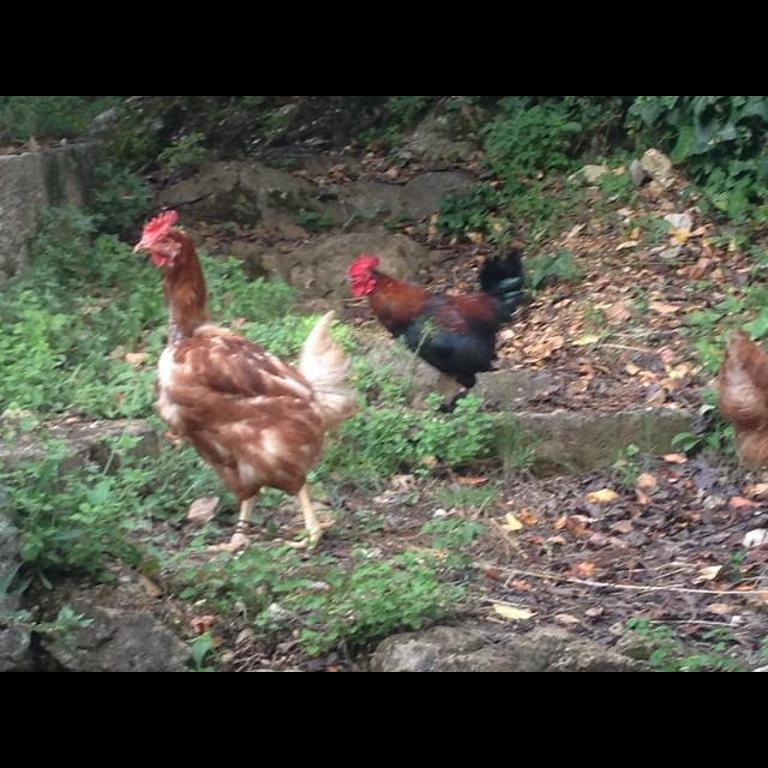

In [8]:
dataset[100]

# MAXM- oliver

In [ ]:
import json
with open('/home/olivernan_cohere_com/okvqa_val_prompt_completion_no_suffix.jsonl', 'r') as f:
    okvqa = [json.loads(line) for line in f]

{'image': 'data/coco/val2014/COCO_val2014_000000229383.jpg',
 'question': 'Is this illegal or legal?',
 'question_id': 2293835,
 'answer': 'legal',
 'prompt': [{'url': ''},
  {'text': 'Is this illegal or legal?'}],
 'completion': 'legal',
 'turns': [{'role': 'User',
   'message': [{'url': ''},
    {'text': 'Is this illegal or legal?'}]}]}
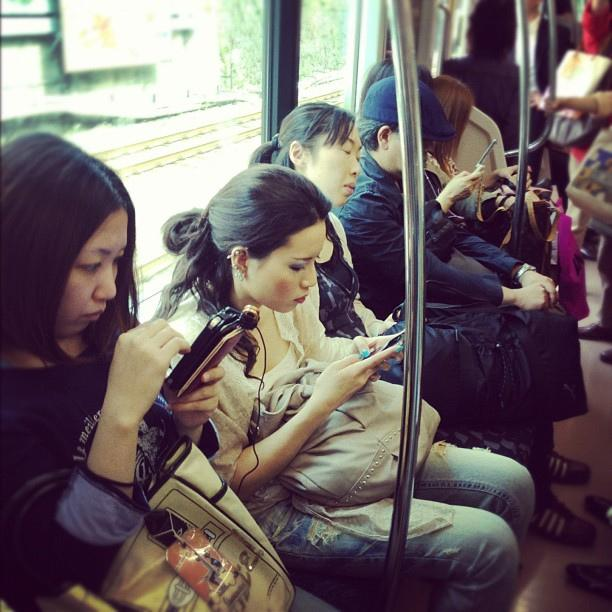
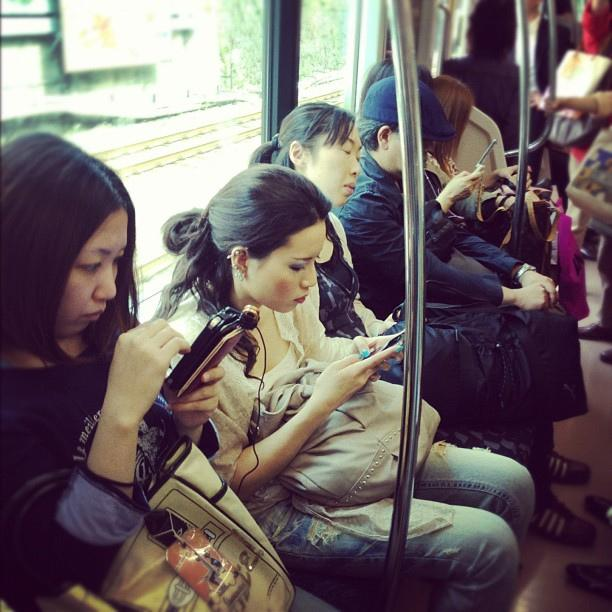

In [8]:
okvqa[0]

In [16]:
with open('/home/olivernan_cohere_com/okvqa_val_prompt_completion_no_suffix.jsonl', 'r') as f:
    okvqa = [json.loads(line) for line in f]

#### Upload to HF version

In [64]:
import requests
from PIL import Image as PILImage
from io import BytesIO
from datasets import Dataset, Features, Sequence, Image, Value
import datasets
def process_image(examples):
    images =[]
    for image_url in examples['image_url']:
        response = requests.get(image_url)
        img = PILImage.open(BytesIO(response.content))
        images.append(img)
        
    return {'image': images}

maxm = datasets.load_dataset('floschne/maxm')
for language in ['en', 'fr', 'zh', 'th', 'iw', 'hi']:
    dataset = maxm[language].select_columns(['image_url', 'question', 'answers', 'language', 'question_id', 'image_id'])

    dataset = dataset.map(
        process_image,
        num_proc=24,  
        batched=True,
        batch_size=48,
        remove_columns=['image_url']
    )

    dataset = datasets.Dataset.from_dict(dataset.to_dict(), 
                                features=Features({
                                    'question': Value(dtype='string', id=None),
                                    'language': Value(dtype='string', id=None),
                                    "answers": Sequence(
                                    feature=Value(dtype="string", id=None), length=-1, id=None
                                    ),
                                    'question_id': Value(dtype='string', id=None),
                                    'image_id': Value(dtype='string', id=None),
                                    'image': Image(mode=None, decode=True, id=None),
                                }))

    dataset.push_to_hub(f'olivernan/maxm', language, split="train")


Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


In [18]:
import io
import base64
import json
import math 
from PIL import Image
import datasets
import os

def to_bytes(image):
    img_byte_arr = io.BytesIO()
    image.convert("RGB").save(img_byte_arr, format="jpeg")
    return img_byte_arr.getvalue()

def resize_and_pad_image(image, target_resolution):
    """
    Resize and pad an image to a target resolution while maintaining aspect ratio.

    Args:
        image (PIL.Image.Image): The input image.
        target_resolution (tuple): The target resolution (width, height) of the image.

    Returns:
        PIL.Image.Image: The resized and padded image.
    """
    original_width, original_height = image.size
    target_width, target_height = target_resolution

    scale_w = target_width / original_width
    scale_h = target_height / original_height

    if scale_w < scale_h:
        new_width = target_width
        new_height = min(math.ceil(original_height * scale_w), target_height)
    else:
        new_height = target_height
        new_width = min(math.ceil(original_width * scale_h), target_width)

    # Resize the image
    resized_image = image.resize((new_width, new_height))

    new_image = Image.new('RGB', (target_width, target_height), (0, 0, 0))
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized_image, (paste_x, paste_y))

    return new_image

# lang = ['en', 'fr', 'zh', 'th', 'iw', 'hi']

os.makedirs('/home/olivernan_cohere_com/maxm_eval_oliver', exist_ok=True)

for lang in ['en', 'fr', 'zh', 'th', 'iw', 'hi']:
    if lang == 'th':
        continue
    dataset = datasets.load_dataset('neulab/PangeaBench-maxm', split = lang)
    if lang == 'zh':
        lang = 'zh-CN'
    if lang == 'iw':
        lang = 'he'
    
    os.makedirs(f'/home/olivernan_cohere_com/maxm_eval_oliver/{aya23_cloudcode2nllbcode[lang]}', exist_ok=True)

    # os.makedirs(f'/home/olivernan_cohere_com/maxm_eval/{lang}', exist_ok=True)

    # dataset = datasets.load_dataset('olivernan/maxm', lang)['train']

    with open(f'/home/olivernan_cohere_com/maxm_eval_oliver/{aya23_cloudcode2nllbcode[lang]}/maxm_{aya23_cloudcode2nllbcode[lang]}_all_resize_762_762.jsonl', "w+") as f:
        for i, data in enumerate(dataset):
            data_json = {}
            data_json['turns'] = []
            data_json['image_id'] = data['image_id']
            data_json['question_id'] = data['question_id']
            data_json['completion'] = "" #data['answers'][0]
            data_json['turns'].append({'role': 'User', "message": []})
            data_json['turns'][0]['message'].append({"text": data['question']})
            image = Image.open(BytesIO(requests.get(data['image_url']).content))
            resized_image = resize_and_pad_image(image, (768, 768))
            data_json['turns'][0]['message'].append({"url": f"data:image/jpeg;base64,{base64.b64encode(to_bytes(resized_image)).decode('utf-8')}"})
            f.write(json.dumps(data_json, ensure_ascii=False) + "\n")

    questions = {}
    questions['license'] = {"url": "http://creativecommons.org/licenses/by/4.0/", "name": "Creative Commons Attribution 4.0 International License"}
    questions['data_subtype'] = "test"
    questions['task_type'] = "Open-Ended"
    questions['info'] = {"year": 2021, "version": "1", "description": "Maxm dataset"}
    questions['data_type'] = "VQ2A-COCO"
    questions['questions'] = []
    with open(f'/home/olivernan_cohere_com/maxm_eval_oliver/{aya23_cloudcode2nllbcode[lang]}/maxm_{aya23_cloudcode2nllbcode[lang]}_questions.json', "w+") as f:
        for i, data in enumerate(dataset):
            data_json = {}
            data_json['question_id'] = data['question_id']
            data_json['image_id'] = data['image_id']
            data_json['question'] = data['question']
            questions['questions'].append(data_json)
        f.write(json.dumps(questions, ensure_ascii=False))

    annotations = {}
    annotations['license'] = {"url": "http://creativecommons.org/licenses/by/4.0/", "name": "Creative Commons Attribution 4.0 International License"}
    annotations['data_subtype'] = "test"
    annotations['data_type'] = "vqa"
    annotations['info'] = {"year": 2021, "version": "1", "description": "Maxm dataset"}
    annotations['data_type'] = "VQ2A-COCO"
    annotations['annotations'] = []
    with open(f'/home/olivernan_cohere_com/maxm_eval_oliver/{aya23_cloudcode2nllbcode[lang]}/maxm_{aya23_cloudcode2nllbcode[lang]}_annotations.json', "w+") as f:
        for i, data in enumerate(dataset):
            data_json = {}
            data_json['question_id'] = data['question_id']
            data_json['image_id'] = data['image_id']
            data_json['answer_type'] = "other"
            data_json['question_type'] = "other"
            data_json['answers'] = []
            for i, answer in enumerate(data['answers']):
                data_json['answers'].append({"answer": answer, "answer_id": i})
            annotations['annotations'].append(data_json)
        f.write(json.dumps(annotations, ensure_ascii=False))

# MAXM- Pangea

In [39]:
import io
import base64
import json
import math 
from PIL import Image
import datasets
import os

def to_bytes(image):
    img_byte_arr = io.BytesIO()
    image.convert("RGB").save(img_byte_arr, format="jpeg")
    return img_byte_arr.getvalue()

def resize_and_pad_image(image, target_resolution):
    """
    Resize and pad an image to a target resolution while maintaining aspect ratio.

    Args:
        image (PIL.Image.Image): The input image.
        target_resolution (tuple): The target resolution (width, height) of the image.

    Returns:
        PIL.Image.Image: The resized and padded image.
    """
    original_width, original_height = image.size
    target_width, target_height = target_resolution

    scale_w = target_width / original_width
    scale_h = target_height / original_height

    if scale_w < scale_h:
        new_width = target_width
        new_height = min(math.ceil(original_height * scale_w), target_height)
    else:
        new_height = target_height
        new_width = min(math.ceil(original_width * scale_h), target_width)

    # Resize the image
    resized_image = image.resize((new_width, new_height))

    new_image = Image.new('RGB', (target_width, target_height), (0, 0, 0))
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized_image, (paste_x, paste_y))

    return new_image

# lang = ['en', 'fr', 'zh', 'th', 'iw', 'hi']

from PIL import Image
import requests
from io import BytesIO

os.makedirs('/home/olivernan_cohere_com/maxm_eval_pangea_all_resize_762_762', exist_ok=True)

for lang in ['en', 'fr', 'zh', 'th', 'iw', 'hi']:
    if lang == 'th':
        continue
    
    dataset = datasets.load_dataset('neulab/PangeaBench-maxm', split = lang)

    if lang == 'zh':
        lang = 'zh-CN'
    if lang == 'iw':
        lang = 'he'

    with open(f'/home/olivernan_cohere_com/maxm_eval_pangea_all_resize_762_762/{aya23_cloudcode2nllbcode[lang]}.jsonl', "w+") as f:
        for i, data in enumerate(dataset):
            data_json = {}
            
            data_json['image_id'] = data['image_id']
            data_json['question_id'] = data['question_id']
            data_json['question'] = data['question']
            data_json['answers'] = data['answers']
            data_json['processed_answers'] = data['processed_answers']
            data_json['image_captions'] = data['image_captions']
            data_json['language'] = aya23_cloudcode2nllbcode[lang]
            data_json['method'] = data['method']
            image = Image.open(BytesIO(requests.get(data['image_url']).content))
            data_json['completion'] = ""
            data_json['turns'] = []
            data_json['turns'].append({'role': 'User', "message": []})
            data_json['turns'][0]['message'].append({"text": data['question']})
            data_json['images'] = []
            resized_image = resize_and_pad_image(image, (768, 768))
            data_json['images'].append(f"data:image/jpeg;base64,{base64.b64encode(to_bytes(resized_image)).decode('utf-8')}")
            data_json['turns'][0]['message'].append({"url": f"data:image/jpeg;base64,{base64.b64encode(to_bytes(resized_image)).decode('utf-8')}"})
            f.write(json.dumps(data_json, ensure_ascii=False) + "\n")

In [ ]:
from PIL import Image
import requests
from io import BytesIO
Image.open(BytesIO(requests.get(datasets.load_dataset('neulab/PangeaBench-maxm', split = 'zh')['image_url'][0]).content))

# XMMMU

In [20]:
import datasets
langs = ['en', 'ar', 'fr', 'hi', 'id', 'ja', 'pt']

In [23]:
xmmmu = datasets.load_dataset('neulab/PangeaBench-xmmmu', split= 'fr')

In [36]:
import io
import base64
import json
import math 
from PIL import Image
import datasets

def to_bytes(image):
    img_byte_arr = io.BytesIO()
    image.convert("RGB").save(img_byte_arr, format="jpeg")
    return img_byte_arr.getvalue()

def resize_and_pad_image(image, target_resolution):
    """
    Resize and pad an image to a target resolution while maintaining aspect ratio.

    Args:
        image (PIL.Image.Image): The input image.
        target_resolution (tuple): The target resolution (width, height) of the image.

    Returns:
        PIL.Image.Image: The resized and padded image.
    """
    original_width, original_height = image.size
    target_width, target_height = target_resolution

    scale_w = target_width / original_width
    scale_h = target_height / original_height

    if scale_w < scale_h:
        new_width = target_width
        new_height = min(math.ceil(original_height * scale_w), target_height)
    else:
        new_height = target_height
        new_width = min(math.ceil(original_width * scale_h), target_width)

    # Resize the image
    resized_image = image.resize((new_width, new_height))

    new_image = Image.new('RGB', (target_width, target_height), (0, 0, 0))
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized_image, (paste_x, paste_y))

    return new_image

In [35]:
multi_choice_example_format = """{question}

{example}

Answer with the option's letter from the given choices directly.
"""


short_ans_example_format = """{question}

Answer the question using a single word or phrase.
"""

In [34]:
import re

def construct_prompt(options, question, question_type, answer):
    
    if question_type == 'multiple-choice':
        example = ""
        start_chr = 'A'
        prediction_range = []
        index2ans = {}
        for option in options:
            prediction_range.append(start_chr)
            example += f"({start_chr}) {option}\n"
            index2ans[start_chr] = option
            start_chr = chr(ord(start_chr) + 1)
        empty_prompt = multi_choice_example_format.format(question = question, example = example)
        
        res_dict = {}
        res_dict['index2ans'] = index2ans
        res_dict['correct_choice'] = answer
        res_dict['all_choices'] = prediction_range
        res_dict['empty_prompt'] = empty_prompt
        res_dict['gt_content'] = options[ord(answer.upper()) - ord('A')]
    else:
        empty_prompt = short_ans_example_format.format(question = question)
        res_dict = {}
        res_dict['empty_prompt'] = empty_prompt
        res_dict['gt_content'] = answer
        res_dict['index2ans'] = None
        res_dict['correct_choice'] = None
        res_dict['all_choices'] = None

    return res_dict

In [37]:
import ast
import os
os.makedirs('/home/olivernan_cohere_com/xmmmu_all_resize_768_768', exist_ok=True)
for lang in langs:

    with open(f"/home/olivernan_cohere_com/xmmmu_all_resize_768_768/{aya23_cloudcode2nllbcode[lang]}.jsonl", 'w') as f:
    
        print(f"language {aya23_cloudcode2nllbcode[lang]}")   
        xmmmu = datasets.load_dataset('neulab/PangeaBench-xmmmu', split = lang) #[datasets.load_dataset('neulab/PangeaBench-xmmmu', split = lang)[257]]
        for i, data in enumerate(xmmmu):
            data_json = {}
            data_json['id'] = data['id']

            processed_dict = construct_prompt(ast.literal_eval(data['options'].replace('\n', ' ')), data['question'], data['question_type'], data['answer'])
            

            # print(processed_dict)
            raw_prompt = processed_dict['empty_prompt']
            data_json['prompt'] = raw_prompt
            data_json['correct_choice'] = processed_dict['correct_choice']
            data_json['index2ans'] = processed_dict['index2ans']
            data_json['all_choices'] = processed_dict['all_choices']
            data_json['gt_content'] = processed_dict['gt_content']
            data_json['completion'] = None

            data_json['language'] = aya23_cloudcode2nllbcode[lang]
            data_json['topic_difficulty'] = data['topic_difficulty']
            data_json['question_type'] = data['question_type']
            data_json['subfield'] = data['subfield']
            data_json['question'] = data['question']
            data_json['answer'] = data['answer']
            data_json['options'] = ast.literal_eval(data['options'].replace('\n', ' '))
            data_json['img_type'] = data['img_type']
        #     print(data_json)
        #     break
        # break
            
            data_json['turns'] = []
            data_json['turns'].append({'role': 'User'})
            content = []

            split_list = re.split(r'(<image \d+>)',raw_prompt)
            data_json['images'] = []
            for i, item in enumerate(split_list):
                if re.match(r'<image \d+>', item):
                    image_column = "image_{}".format(re.findall(r'\d+', item)[0])
                    if data[image_column] is not None:
                        resized_image = resize_and_pad_image(data[image_column], (768, 768))
                        content.append({"url": f"data:image/jpeg;base64,{base64.b64encode(to_bytes(resized_image)).decode('utf-8')}"})
                        data_json['images'].append(f"data:image/jpeg;base64,{base64.b64encode(to_bytes(resized_image)).decode('utf-8')}")
                else:
                    if (not item.isspace()) and (item != "") and (item is not None):
                        content.append({"text": item})

            data_json['turns'][0]['message'] = content

                    
            
            # # print("rest")
            # # print(rest_of_prompt.isspace())
            # if (not rest_of_prompt.isspace()) and (rest_of_prompt != "") and (rest_of_prompt is not None):
            #     content.append({"text": rest_of_prompt})
            
        #     print(data_json['raw_prompt'])
        #     for x in data_json['turns'][0]['message']:
        #         print(x)
        #     break
        # break
            
            f.write(json.dumps(data_json, ensure_ascii=False) + "\n")

language eng_Latn


/home/olivernan_cohere_com/miniconda3/envs/instructmultilingual/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


language arb_Arab
language fra_Latn
language hin_Deva
language ind_Latn
language jpn_Jpan
language por_Latn


# m-ArenaHard

In [41]:
import datasets
# ['ar', 'cs', 'de', 'el', 'en', 'es', 'fa', 'fr', 'he', 'hi', 'id', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'ro', 'ru', 'tr', 'uk', 'vi', 'zh']

ar = datasets.load_dataset('CohereForAI/m-ArenaHard', 'ar')['test']
ar = ar.add_column('language', [aya23_cloudcode2nllbcode['ar']]* len(ar))
cs = datasets.load_dataset('CohereForAI/m-ArenaHard', 'cs')['test']
cs = cs.add_column('language', [aya23_cloudcode2nllbcode['cs']]* len(cs))
de = datasets.load_dataset('CohereForAI/m-ArenaHard', 'de')['test']
de = de.add_column('language', [aya23_cloudcode2nllbcode['de']]* len(de))
el = datasets.load_dataset('CohereForAI/m-ArenaHard', 'el')['test']
el = el.add_column('language', [aya23_cloudcode2nllbcode['el']]* len(el))
en = datasets.load_dataset('CohereForAI/m-ArenaHard', 'en')['test']
en = en.add_column('language', [aya23_cloudcode2nllbcode['en']]* len(en))
es = datasets.load_dataset('CohereForAI/m-ArenaHard', 'es')['test']
es = es.add_column('language', [aya23_cloudcode2nllbcode['es']]* len(es))
fa = datasets.load_dataset('CohereForAI/m-ArenaHard', 'fa')['test']
fa = fa.add_column('language', [aya23_cloudcode2nllbcode['fa']]* len(fa))
fr = datasets.load_dataset('CohereForAI/m-ArenaHard', 'fr')['test']
fr = fr.add_column('language', [aya23_cloudcode2nllbcode['fr']]* len(fr))
he = datasets.load_dataset('CohereForAI/m-ArenaHard', 'he')['test']
he = he.add_column('language', [aya23_cloudcode2nllbcode['he']]* len(he))
hi = datasets.load_dataset('CohereForAI/m-ArenaHard', 'hi')['test']
hi = hi.add_column('language', [aya23_cloudcode2nllbcode['hi']]* len(hi))
id = datasets.load_dataset('CohereForAI/m-ArenaHard', 'id')['test']
id = id.add_column('language', [aya23_cloudcode2nllbcode['id']]* len(id))
it = datasets.load_dataset('CohereForAI/m-ArenaHard', 'it')['test']
it = it.add_column('language', [aya23_cloudcode2nllbcode['it']]* len(it))
ja = datasets.load_dataset('CohereForAI/m-ArenaHard', 'ja')['test']
ja = ja.add_column('language', [aya23_cloudcode2nllbcode['ja']]* len(ja))
ko = datasets.load_dataset('CohereForAI/m-ArenaHard', 'ko')['test']
ko = ko.add_column('language', [aya23_cloudcode2nllbcode['ko']]* len(ko))
nl = datasets.load_dataset('CohereForAI/m-ArenaHard', 'nl')['test']
nl = nl.add_column('language', [aya23_cloudcode2nllbcode['nl']]* len(nl))
pl = datasets.load_dataset('CohereForAI/m-ArenaHard', 'pl')['test']
pl = pl.add_column('language', [aya23_cloudcode2nllbcode['pl']]* len(pl))
pt = datasets.load_dataset('CohereForAI/m-ArenaHard', 'pt')['test']
pt = pt.add_column('language', [aya23_cloudcode2nllbcode['pt']]* len(pt))
ro = datasets.load_dataset('CohereForAI/m-ArenaHard', 'ro')['test']
ro = ro.add_column('language', [aya23_cloudcode2nllbcode['ro']]* len(ro))
ru = datasets.load_dataset('CohereForAI/m-ArenaHard', 'ru')['test']
ru = ru.add_column('language', [aya23_cloudcode2nllbcode['ru']]* len(ru))
tr = datasets.load_dataset('CohereForAI/m-ArenaHard', 'tr')['test']
tr = tr.add_column('language', [aya23_cloudcode2nllbcode['tr']]* len(tr))
uk = datasets.load_dataset('CohereForAI/m-ArenaHard', 'uk')['test']
uk = uk.add_column('language', [aya23_cloudcode2nllbcode['uk']]* len(uk))
vi = datasets.load_dataset('CohereForAI/m-ArenaHard', 'vi')['test']
vi = vi.add_column('language', [aya23_cloudcode2nllbcode['vi']]* len(vi))
zh = datasets.load_dataset('CohereForAI/m-ArenaHard', 'zh')['test']
zh = zh.add_column('language', [aya23_cloudcode2nllbcode['zh-CN']]* len(zh))

# dataset = datasets.concatenate_datasets([ar, cs, de, el, en, es, fa, fr, he, hi, id, it, ja, ko, nl, pl, pt, ro, ru, tr, uk, vi, zh])
dataset_list = [ar, cs, de, el, en, es, fa, fr, he, hi, id, it, ja, ko, nl, pl, pt, ro, ru, tr, uk, vi, zh]

In [43]:
import json
import os
os.makedirs('/home/olivernan_cohere_com/mArenaHard_raw/', exist_ok=True)

index = 0
new_dataset = []
with open('/home/olivernan_cohere_com/mArenaHard_raw/aya23.jsonl', "w+") as all_file:
    for dataset in dataset_list:
        lang = dataset['language'][0]
        # with open(f'/home/olivernan_cohere_com/mArenaHard_raw/{lang}.jsonl', "w+") as f:
        for _, data in enumerate(dataset):
            data_json = {}
            data_json['prompt'] = data['prompt']
            data_json['turns'] = []
            data_json['turns'].append({'role': 'User', "message": []})
            data_json['turns'][0]['message'].append({"text": data['prompt']})
            data_json['completion'] = ""
            data_json['language'] = data['language']
            data_json['cluster'] = data['cluster']
            data_json['index'] = index
            # f.write(json.dumps(data_json, ensure_ascii=False) + "\n")
            new_dataset.append(data_json)
            all_file.write(json.dumps(data_json, ensure_ascii=False) + "\n")
            index += 1

In [48]:
# dataset = []
# for lang in os.listdir('/home/olivernan_cohere_com/mArenaHard/'):
#     with open(f'/home/olivernan_cohere_com/mArenaHard/{lang}', 'r') as f:
#         dataset += [json.loads(line) for line in f]


# with open('/home/olivernan_cohere_com/mArenaHard/aya23.jsonl', 'w') as out_file:
#     for line in dataset:
#         out_file.write(json.dumps(line, ensure_ascii=False) + "\n")
import pandas as pd
mArenaHard = pd.read_json('/home/olivernan_cohere_com/mArenaHard_raw/aya23.jsonl', lines=True)

for language in mArenaHard['language'].unique():
    print(language)
    dataset= mArenaHard[mArenaHard['language'] == language]
    with open(f'/home/olivernan_cohere_com/mArenaHard_raw/{language}.jsonl', 'w', encoding='utf-8') as file: 
        dataset.to_json(file, orient='records', lines=True, force_ascii=False)

arb_Arab
ces_Latn
deu_Latn
ell_Grek
eng_Latn
spa_Latn
pes_Arab
fra_Latn
heb_Hebr
hin_Deva
ind_Latn
ita_Latn
jpn_Jpan
kor_Hang
nld_Latn
pol_Latn
por_Latn
ron_Latn
rus_Cyrl
tur_Latn
ukr_Cyrl
vie_Latn
zho_Hans


# Cauldron Win Rate

### Google Translate

In [ ]:
from google.cloud import translate_v3
import time

PROJECT_ID = "valued-sight-253418"

def translate_text(text, target_language_code):
    """Translating Text."""

    client = translate_v3.TranslationServiceClient()

    parent = f"projects/{PROJECT_ID}"

    tries = 0

    while tries < 10:
        try:
            response = client.translate_text(
                    parent = parent,
                    contents= [text],
                    mime_type= "text/plain",  
                    source_language_code= "en-US",
                    target_language_code= target_language_code,
            )
            return  response.translations[0].translated_text #[translation.translated_text for translation in response.translations]
        
        except Exception as e:
                print(e)
                time.sleep(5)
                tries += 1
                continue

    return None

In [ ]:
import datasets

dataset = datasets.load_dataset("olivernan/cauldron_eval_sample_w_gpt_questions")['train']
dataset = dataset.rename_columns({"random_pick_generated_question": "question_en"})

for nllbcode, cloudecode in aya23_nllbcode2cloudcode.items():
    print(f"Translating to {lang}")
    if cloudecode == "en":
        continue
    column_name = f"question_{nllbcode}"
    print(column_name)
    dataset = dataset.map(lambda x: {column_name: translate_text(x["question_en"], cloudecode)}, num_proc=10)


In [ ]:
from datasets import Dataset, Features, Sequence, Image, Value

dataset_columns = dataset.column_names
column_reorder = ["index"] + [col for col in dataset_columns if col != "index"]
dataset_reordered = dataset.select_columns(column_reorder).to_dict()

dataset_reordered = datasets.Dataset.from_dict(dataset_reordered, 
                                features=Features({
                                    'index': Value(dtype='int32', id=None),
                                    'image': Sequence(feature=Image(mode=None, decode=True, id=None), length=-1, id=None), 
                                    'data_source': Value(dtype='string', id=None),
                                    'task_category': Value(dtype='string', id=None),
                                    "gpt_4o_generated_questions": Sequence(
                                        feature=Value(dtype="string", id=None), length=-1, id=None
                                    ),
                                    "question_en": Value(dtype="string", id=None),
                                    "question_ar": Value(dtype="string", id=None),
                                    "question_zh-CN": Value(dtype="string", id=None),
                                    "question_zh-TW": Value(dtype="string", id=None),
                                    "question_cs": Value(dtype="string", id=None),
                                    "question_nl": Value(dtype="string", id=None),
                                    "question_fr": Value(dtype="string", id=None),
                                    "question_de": Value(dtype="string", id=None),
                                    "question_el": Value(dtype="string", id=None),
                                    "question_he": Value(dtype="string", id=None),
                                    "question_hi": Value(dtype="string", id=None),
                                    "question_id": Value(dtype="string", id=None),
                                    "question_it": Value(dtype="string", id=None),
                                    "question_ja": Value(dtype="string", id=None),
                                    "question_ko": Value(dtype="string", id=None),
                                    "question_fa": Value(dtype="string", id=None),
                                    "question_pl": Value(dtype="string", id=None),
                                    "question_pt": Value(dtype="string", id=None),
                                    "question_ro": Value(dtype="string", id=None),
                                    "question_ru": Value(dtype="string", id=None),
                                    "question_es": Value(dtype="string", id=None),
                                    "question_tr": Value(dtype="string", id=None),
                                    "question_uk": Value(dtype="string", id=None),
                                    "question_vi": Value(dtype="string", id=None),
                                })
                                )

In [ ]:
dataset_reordered.push_to_hub("olivernan/cauldron_eval_sample_w_gpt_questions_aya23languages")

#### Bee formatting

In [33]:
import io
import base64
import json
import math 
from PIL import Image
import datasets
import os


def to_bytes(image):
    img_byte_arr = io.BytesIO()
    image.convert("RGB").save(img_byte_arr, format="jpeg")
    return img_byte_arr.getvalue()

def resize_and_pad_image(image, target_resolution):
    """
    Resize and pad an image to a target resolution while maintaining aspect ratio.

    Args:
        image (PIL.Image.Image): The input image.
        target_resolution (tuple): The target resolution (width, height) of the image.

    Returns:
        PIL.Image.Image: The resized and padded image.
    """
    original_width, original_height = image.size
    target_width, target_height = target_resolution

    scale_w = target_width / original_width
    scale_h = target_height / original_height

    if scale_w < scale_h:
        new_width = target_width
        new_height = min(math.ceil(original_height * scale_w), target_height)
    else:
        new_height = target_height
        new_width = min(math.ceil(original_width * scale_h), target_width)

    # Resize the image
    resized_image = image.resize((new_width, new_height))

    new_image = Image.new('RGB', (target_width, target_height), (0, 0, 0))
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized_image, (paste_x, paste_y))

    return new_image

# with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768.jsonl', "w+") as f:


dataset = datasets.load_dataset("olivernan/cauldron_eval_sample_w_gpt_questions_aya23languages")['train']
os.makedirs('/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768', exist_ok=True)
new_dataset = []
index = 0
for nllbcode, cloudecode in aya23_nllbcode2cloudcode.items():
    column_name = f"question_{nllbcode}"
    # with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768/{nllbcode}.jsonl', "w") as f:
    for i, data in enumerate(dataset):
        # column_name = f"question_{key}"
        # column_name = f"question_{nllbcode}"
        data_json = {}
        data_json['images'] = []
        data_json['turns'] = []
        data_json['turns'].append({'role': 'User', "message": []})
        data_json['turns'][0]['message'].append({"text": data[column_name]})
        for image in data['image']:
            resized_image = resize_and_pad_image(image, (768, 768))
            data_json['turns'][0]['message'].append({"url": f"data:image/jpeg;base64,{base64.b64encode(to_bytes(resized_image)).decode('utf-8')}"})
            data_json['images'].append(f"data:image/jpeg;base64,{base64.b64encode(to_bytes(resized_image)).decode('utf-8')}")
        data_json['prompt'] = data[column_name]
        data_json['completion'] = ""
        data_json['index'] = index
        data_json['data_source'] = data['data_source']
        data_json['task_category'] = data['task_category']
        data_json['language'] = nllbcode
        # f.write(json.dumps(data_json, ensure_ascii=False) + "\n")
        new_dataset.append(data_json)
        index += 1

with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768/aya23.jsonl', "w+") as f:
    for data in new_dataset:
        f.write(json.dumps(data, ensure_ascii=False) + "\n")

In [51]:
# with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768/aya23.jsonl', "r") as f:
#     dataset = [json.loads(line) for line in f]

import pandas as pd
cauldron = pd.read_json('/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768-Pangea-7B/aya23.jsonl', lines=True)

for language in cauldron['language'].unique():
    print(language)
    dataset= cauldron[cauldron['language'] == language]
    with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768-Pangea-7B/{language}.jsonl', 'w', encoding='utf-8') as file: 
        dataset.to_json(file, orient='records', lines=True, force_ascii=False)

deu_Latn
ell_Grek
heb_Hebr
hin_Deva
ind_Latn
ita_Latn
jpn_Jpan
pes_Arab
pol_Latn
kor_Hang
ukr_Cyrl
vie_Latn
ron_Latn
rus_Cyrl
tur_Latn
nld_Latn
eng_Latn
por_Latn
fra_Latn
arb_Arab
zho_Hans
spa_Latn
zho_Hant
ces_Latn


#### downsampling

In [57]:
TASKS = list(set(dataset['task_category']))

os.makedirs('/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768_downsample_135-Pangea-7B', exist_ok=True)

dataset = pd.read_json('/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768-Pangea-7B/aya23.jsonl', lines=True)

# # with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768_downsample_135.jsonl', "w+") as f:
# new_dataset = []
# index = 0
# for task in TASKS:
#     task_data = dataset.filter(lambda x: x['task_category'] == task).shuffle(seed = 16).select(range(15))
#     print(task_data)
#     print(len(task_data))
#     for nllbcode, cloudecode in aya23_nllbcode2cloudcode.items():
#         column_name = f"question_{nllbcode}"
#         with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768_downsample_135-Pangea-7B/{nllbcode}.jsonl', "w") as f:
#             for i, data in enumerate(task_data):
#                 data['index'] = index 
#                 f.write(json.dumps(data,ensure_ascii=False) + "\n")
#                 new_dataset.append(data)
#                 index += 1

new_dataset = []
for lang in dataset['language'].unique():
    # print(lang)
    lang_dataset = dataset[dataset['language'] == lang]
    for task in dataset['task_category'].unique():
        task_data = lang_dataset[lang_dataset['task_category'] == task].sample(n=15, random_state=16)
        for _, data in task_data.iterrows():
            data = data.to_dict()
            data['index'] = index
            new_dataset.append(data)
            index += 1

print(len(new_dataset))
with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768_downsample_135-Pangea-7B/aya23.jsonl', "w+") as f:
    for data in new_dataset:
        f.write(json.dumps(data, ensure_ascii=False) + "\n")

downsample = pd.read_json('/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768_downsample_135-Pangea-7B/aya23.jsonl', lines=True)
for language in downsample['language'].unique():
    print(language)
    dataset= downsample[downsample['language'] == language]
    with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768_downsample_135-Pangea-7B/{language}.jsonl', 'w', encoding='utf-8') as file: 
        dataset.to_json(file, orient='records', lines=True, force_ascii=False)

3240
deu_Latn
ell_Grek
heb_Hebr
hin_Deva
ind_Latn
ita_Latn
jpn_Jpan
pes_Arab
pol_Latn
kor_Hang
ukr_Cyrl
vie_Latn
ron_Latn
rus_Cyrl
tur_Latn
nld_Latn
eng_Latn
por_Latn
fra_Latn
arb_Arab
zho_Hans
spa_Latn
zho_Hant
ces_Latn


In [17]:
TASKS = list(set(dataset['task_category']))

os.makedirs('/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768_downsample_135', exist_ok=True)

# with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768_downsample_135.jsonl', "w+") as f:
new_dataset = []
for task in TASKS:
    task_data = dataset.filter(lambda x: x['task_category'] == task).shuffle(seed = 16).select(range(15))
    print(task_data)
    print(len(task_data))
    for nllbcode, cloudecode in aya23_nllbcode2cloudcode.items():
        column_name = f"question_{nllbcode}"
        with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768_downsample_135/{nllbcode}.jsonl', "w") as f:
            for i, data in enumerate(task_data):
                data_json = {}
                data_json['images'] = []
                data_json['turns'] = []
                data_json['turns'].append({'role': 'User', "message": []})
                data_json['turns'][0]['message'].append({"text": data[column_name]})
                for image in data['image']:
                    # width, height = image.size
                    # if width >= 256 or height >= 256:
                    resized_image = resize_and_pad_image(image, (768, 768))
                    data_json['turns'][0]['message'].append({"url": f"data:image/jpeg;base64,{base64.b64encode(to_bytes(resized_image)).decode('utf-8')}"})
                    data_json['images'].append(f"{base64.b64encode(to_bytes(image)).decode('utf-8')}")
                data_json['prompt'] = data[column_name]
                data_json['completion'] = ""
                data_json['index'] = data['index']
                data_json['data_source'] = data['data_source']
                data_json['task_category'] = data['task_category']
                data_json['language'] = nllbcode
                f.write(json.dumps(data_json,ensure_ascii=False) + "\n")
                new_dataset.append(data_json)

with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768_downsample_135/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768_downsample_135_all.jsonl', "w+") as f:
    for data in new_dataset:
        f.write(json.dumps(data, ensure_ascii=False) + "\n")

Dataset({
    features: ['image', 'data_source', 'task_category', 'gpt_4o_generated_questions', 'question_eng_Latn', 'index', 'question_arb_Arab', 'question_zho_Hans', 'question_zho_Hant', 'question_ces_Latn', 'question_nld_Latn', 'question_fra_Latn', 'question_deu_Latn', 'question_ell_Grek', 'question_heb_Hebr', 'question_hin_Deva', 'question_ind_Latn', 'question_ita_Latn', 'question_jpn_Jpan', 'question_kor_Hang', 'question_pes_Arab', 'question_pol_Latn', 'question_por_Latn', 'question_ron_Latn', 'question_rus_Cyrl', 'question_spa_Latn', 'question_tur_Latn', 'question_ukr_Cyrl', 'question_vie_Latn'],
    num_rows: 15
})
15
Dataset({
    features: ['image', 'data_source', 'task_category', 'gpt_4o_generated_questions', 'question_eng_Latn', 'index', 'question_arb_Arab', 'question_zho_Hans', 'question_zho_Hant', 'question_ces_Latn', 'question_nld_Latn', 'question_fra_Latn', 'question_deu_Latn', 'question_ell_Grek', 'question_heb_Hebr', 'question_hin_Deva', 'question_ind_Latn', 'question_

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAJdAZYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACivJdC07TbrU/FEl34C/t2T+3Lkfa/Is3wPl+XM0itx16Y5r0/TIIbbTLaK3sF0+JYxttAqL5PfbhCV49iR70AW6KKKACiiigAooooAKKKKACiiigAooooAKKKK
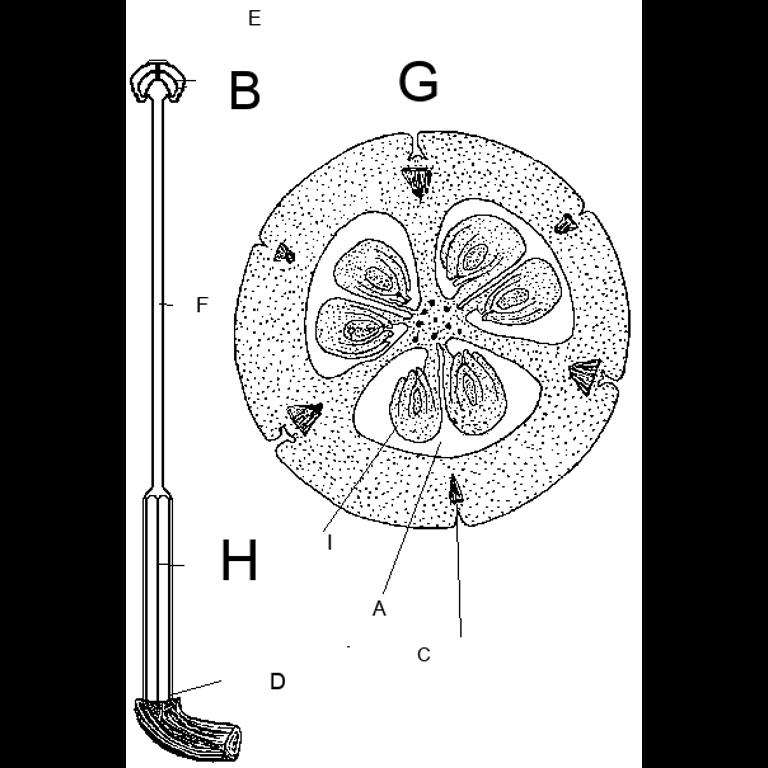

In [21]:
with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23_all_resize_768_768_downsample_135.jsonl', "r") as f:
    dataset = [json.loads(line) for line in f]
dataset[132]

In [ ]:
new_dataset = []

for lang in os.listdir('/home/olivernan_cohere_com/mArenaHard-c4ai-aya-ex-8b'):
    with open(f'/home/olivernan_cohere_com/mArenaHard-c4ai-aya-ex-8b/{lang}', 'r') as f:
        new_dataset += [json.loads(line) for line in f]

with open(f'/home/olivernan_cohere_com/mArenaHard-c4ai-aya-ex-8b/aya23.jsonl', "w+") as f:
    for data in new_dataset:
        f.write(json.dumps(data, ensure_ascii=False) + "\n")